# **Генеративные состязательные сети (Generative adversarial networks)**



## Импорт необходимых библиотек

In [1]:
import os
import random
from pathlib import Path
from collections import OrderedDict

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataloader import default_collate
from torchvision.datasets import ImageFolder
import torchvision.transforms as tfs

import torch
import torch.nn as nn
from PIL import Image
import cv2

from tqdm.notebook import tqdm, trange

from torchvision.utils import save_image
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

In [37]:
# Загрзузка, разархивирование, удаление лишних директорий, переименование основной директории(это всё для удобства использования ImageFolder)
# !gdown -q --fuzzy https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing
# !unzip -q faces_dataset_small.zip -d faces_dataset
# !rm -r faces_dataset/__MACOSX
# !rm -r faces_dataset/faces_dataset_small/04000
# !mv faces_dataset/faces_dataset_small faces_dataset/images

Фиксируем рандом

In [2]:
# Сразу ГСЧ зафиксируем, насколько это возможно вообще.
# Всё равно останется некоторая вариативность.

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

Определяем константы

In [3]:

# Сразу определим путь к файлам, размер изображений, размер батча и девайс
RESCALE_SIZE = 128

BATCH_SIZE = 64

DEVICE = torch.device('cuda') if  torch.cuda.is_available() else torch.device('cpu')
print(f'Доступное устройство: {DEVICE}')

# Директория с изображениями
DATA_DIR = Path('faces_dataset')

Доступное устройство: cuda


Препроцессим изображения, сохраняем в torch.Tensor , из оперативки их читать гораздо быстрее, чем с диска.

In [4]:
# Количество изоражений в датасете
img_num = len(list(DATA_DIR.rglob('*.png')))

# Базовые трансформации
base_transform = tfs.Compose([
                tfs.Resize(RESCALE_SIZE, interpolation=tfs.InterpolationMode.BICUBIC),
                tfs.ToTensor(),
                tfs.Normalize((.5,.5,.5),(.5,.5,.5))])

# Запишем предварительно обработанные данные в тензор.
# Если читать их сразу из оперативки - получится гораздо быстрее
preprocessed_files = torch.empty(size=(img_num,3,RESCALE_SIZE,RESCALE_SIZE))
idx = 0
for dirpath, dirnames, filenames in os.walk(DATA_DIR):
        for fname in filenames:
            if fname.endswith(".png"):
                temp_img = Image.open(os.path.join(dirpath,fname))
                preprocessed_files[idx] = base_transform(temp_img)
                idx += 1

Функция денормализации (приводим из диапазона [-1,1] к [0,1] для визуализации)

In [5]:
# Поскольку изображения у нас нормализованы к диапазону [-1,1] - для визуализации нужно их привести к диапазону [0,1]
# Функция денормализации
def denorm(image):
    return image*0.5+0.5

Враппер для датасета, чтобы аугментации использовать

In [6]:
# Класс как обёртка, для того, чтобы RandomHorizontalFlip использовать
class FacesDataset(Dataset):
    def __init__(self, images):
        super().__init__()
        self.trf = tfs.Compose([
            tfs.RandomHorizontalFlip()
        ])
        self.images = images
    def __getitem__(self, idx):
        return self.trf(self.images[idx])
    def __len__(self):
        return len(self.images)

In [7]:
# Создаём датасет на базе предобработанных файлов и даталоадер
faces_dataset = FacesDataset(preprocessed_files)
base_dataloader = DataLoader(faces_dataset, batch_size=BATCH_SIZE,shuffle=True, pin_memory=True)

Пишем "обёртку" для стандартного даталоадера, которая позволяет сразу перекидывать данные на девайс(cpu ил gpu)

In [8]:

# В целом не очень понятно зачем заворачивать создание даталоадера в функцию, но раз надо - сделаем по аналогии с предыдущим семинаром.
# Для этого напишем вспомогательные функции(так же как в семинаре): to_device и класс DeviceDataloader
def to_device(data, device):
    """Переносим тензоры на выбранный девайс"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# Это просто "обёртка" над стандартным даталоадером, позволяющая сразу перекидывать данные на девайс
class DeviceDataLoader():
    """Обёртка для лоадера: исходный лоадер и девайс передаем как аргументы"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Через yield получаем батч уже перекинутый на девайс"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Количество батчей"""
        return len(self.dl)

In [9]:
# Создаём даталоадер, который перекидывает батчи на девайс
faces_dataloader = DeviceDataLoader(base_dataloader,DEVICE)

## Часть 2. Построение и обучение модели

- дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

- генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

* 1. В дискриминаторе в каждом слое добавил шум. Это своеобразная регуляризация. Усложняем задачу для дискриминатора.
* 2. В генераторе использовал тоже LeakyReLU как и в дискриминаторе. Результат чуть лучше получился.
* 3. Также в генераторе добавил дропауты. Вычитал в статье по GAN-хакам. Про добавление шума вычитал там же и про label smoothing.
* 4. Все свёртки инициализировал нормальным распределением с матожиданием 0 и стандартным отклонением 0.02 Эти значения были рекомендованы в оригинальной статье по DCGAN.

In [10]:
# Гауссов шум (будем добавлять к каждому слою дискриминатора)
class GaussianNoise(nn.Module):                       
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

# Дискриминатор
class Discriminator(nn.Module):
    def __init__(self, image_size, fl_channels):
        super(Discriminator,self).__init__()

        # Расчитываем количество итераций даунcэмплинга, ориентируясь на размер изображения.
        num_iters = int(np.log2(image_size)-3)
        
        self.main = nn.Sequential(OrderedDict([
                ('gauss_1', GaussianNoise()),
                ('conv_1', nn.Conv2d(3,fl_channels, kernel_size=4, stride=2, padding=1, bias=False)),
                ('activation_1', nn.LeakyReLU(0.2, inplace=True))
        ]))
        
        # В цикле добаляем блоки "свёртка, батчнорм, активация"
        for i in range(num_iters):
            self.main.add_module(f'gauss_{i+2}', GaussianNoise())
            self.main.add_module(f'conv_{i+2}', nn.Conv2d(fl_channels*2**i, fl_channels*2**(i+1), kernel_size=4, stride=2, padding=1, bias=False))
            self.main.add_module(f'batchnorm_{i+2}', nn.BatchNorm2d(fl_channels*2**(i+1)))
            self.main.add_module(f'activation_{i+2}', nn.LeakyReLU(0.2, inplace=True))
        
        # Добавляем финальный блок.
        self.main.add_module('final_gaussian', GaussianNoise())
        self.main.add_module('final_conv', nn.Conv2d(fl_channels*2**num_iters, 1, kernel_size=4, stride=1, padding=0, bias=False))
        self.main.add_module('flatten', nn.Flatten())
        self.main.add_module('sigmoid', nn.Sigmoid())
        
        # Инициализируем веса нормальным распределением с матожиданием 0 и стандартным отклонением 0.02
        # Это рекомендованные значения из статьи по DCGAN
        for m in self.main.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
    
    def forward(self,x):
        return self.main(x)

In [11]:
# Генератор
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, fl_channels):
        super(Generator, self).__init__()
        
        # Расчитываем количество итераций апсэмплинга, ориентируясь на размер изображения.
        num_iters = int(np.log2(image_size)-3)
        
        self.main = nn.Sequential(OrderedDict([
                ('upconv_1', nn.ConvTranspose2d(latent_size,fl_channels*2**num_iters, kernel_size=4, stride=1, padding=0, bias=False)),
                ('batchnorm_1', nn.BatchNorm2d(fl_channels*2**num_iters)),
                ('activation_1', nn.ReLU(inplace=True)),
                ('dropout_1', nn.Dropout2d(0.3))
        ]))
        
        # В цикле добаляем блоки "транспонированная свёртка, батчнорм, активация"
        for i in range(num_iters, 0, -1):
            self.main.add_module(f'upconv_{num_iters-i+2}', nn.ConvTranspose2d(fl_channels*2**(i), fl_channels*2**(i-1), kernel_size=4, stride=2, padding=1, bias=False))
            self.main.add_module(f'batchnorm_{num_iters-i+2}', nn.BatchNorm2d(fl_channels*2**(i-1)))
            self.main.add_module(f'activation_{num_iters-i+2}', nn.LeakyReLU(0.2, inplace=True))
            self.main.add_module(f'dropout_{num_iters-i+2}', nn.Dropout2d(0.3))
        
        # Добавляем финальный блок.        
        self.main.add_module(f'final_upconv', nn.ConvTranspose2d(fl_channels, 3, kernel_size=4, stride=2, padding=1, bias=False))
        self.main.add_module(f'tanh', nn.Tanh())
        
        # Инициализируем веса нормальным распределением с матожиданием 0 и стандартным отклонением 0.02
        # Это рекомендованные значения из статьи по DCGAN
        for m in self.main.modules():
            if isinstance(m, (nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
    
    def forward(self,x):
        return self.main(x)

Обучение модели. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1, добавляем label smoothing
  * генерируем изображения генератором и присваиваем им метку 0, добавляем label smoothing
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [12]:
# Создаём директорию для записи сгенерированных изображений
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

Функция для сохранения и визуализации сгенерированных изображений

In [13]:
# Функция для сохранения сгенерированных изображений и визуализации при необходимости
@torch.no_grad()
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    # print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

**Попробовал много разных вариантов.**
1. При увеличении количества каналов(свёрток) результат получается чуть более детализированным. Но за это приходится платить почти 8-кратным увеличением времени обучения. <br> 128-256-512-1024 в дискриминаторе и соответственно зеркально в генераторе дали результат лучше, но на моей локальной машине сеть училась около 30 часов.
2. Пробовал менять lr. Чёткой зависимости результатов не уловил. Но мне кажется получилось чуть лучше при использовании двух multistep schedulers, с разным количеством шагов.
3. Пробовал другие оптимизаторы применять, результаты только хуже оказались. <br>Даже adamW с ровно такими же рекомендуемыми настройками и включенным amsgrad дал результат чуть хуже(хотя может быть это мне просто кажется.)
4. Сильное увеличение размерности латентных векторов к сожалению результат ухудшает. Лучшие результаты у меня получились с векторами длиной 128 и 256. Оставил 128.
5. Размер батча чем больше тем лучше, при его уменьшении обучение становится очень нестабильным. На моей карте с 6 гигами vram максимальный батч при такой архитектуре возможно поставить 64. <br> Возможно с батчем в 128 обучение проходило бы ещё лучше.

Определяем константы, создаём генератор, дискриминатор, лоссы и оптимизаторы.

In [14]:
# Определяем количество карт признаков первого слоя дискриминатора
fl_channels = 64
# Определяем размер латентного вектора
latent_size = 128
# Определяем learning rate для генератора и дискриминатора
g_lr = 0.0002
d_lr = 0.0002
# Создаем 64 случайных вектора, для визуализации. (чтобы контролировать процесс обучения)
fixed_latent = torch.randn(64, latent_size, 1, 1, device=DEVICE)

# Создаём генератор и дискриминатор
discriminator = Discriminator(RESCALE_SIZE,fl_channels).to(DEVICE)
generator = Generator(latent_size, RESCALE_SIZE, fl_channels).to(DEVICE)
# Записываем их в словарь
model = {
    "discriminator": discriminator,
    "generator": generator
}

# Создаём две функции потерь, для дискриминатора и генератора
criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

# Создаём оптимизаторы для генератора и дискриминатора
optimizer = {
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                        lr=d_lr, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(model["generator"].parameters(),
                                    lr=g_lr, betas=(0.5, 0.999))
}

Функция обучения

In [15]:
# Функция обучения
# Добавляем label smoothing, коэффициент сглаживания передаем как параметр функции.
def fit(model, optimizer, criterion, epochs, start_idx=1, smooth=0.1):
    model["discriminator"].train()
    torch.cuda.empty_cache()
    
    # Создаем пустые списки для функции потерь и метрик.
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    sched_d = torch.optim.lr_scheduler.MultiStepLR(optimizer['discriminator'], milestones=[75,150,225,300], gamma=0.9)
    sched_g = torch.optim.lr_scheduler.MultiStepLR(optimizer['generator'], milestones=[150,225,300], gamma=0.9)
    pbar = trange(epochs, desc='Epoch:')
    
    for epoch in pbar:
        # Переводим генератор в режим обучения
        model["generator"].train()
        # Лоссы и скоры за эпоху
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        
        for real_images in faces_dataloader:
            # Обучаем дискриминатор
            # Обнуляем градиенты оптимизатора
            optimizer["discriminator"].zero_grad()

            # Прогоняем реальные изображения через дискриминатор. Задаем им лэйблы = 1
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=DEVICE)
            # Label smoothing
            real_targets = torch.empty_like(real_targets).uniform_(1.0-smooth,1.0)
            # Считаем лосс и скор на реальных изображениях
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Генерируем фейковые изображения
            latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)

            # Задаем лэйблы
            fake_targets = torch.zeros(fake_images.size(0), 1, device=DEVICE)
            # Label smoothing
            fake_targets = torch.empty_like(fake_targets).uniform_(0.0,smooth)
            
            # Прогоняем фейковые изображения через дискриминатор            
            fake_preds = model["discriminator"](fake_images)
            # Считаем лосс и скор на фейковых изображенияъ
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            # Добавляем обе метрики в списки
            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Делаем шаг градиентного спуска для дискриминатора
            # Лосс считаем как сумму лоссов на реальных и фейковых изображениях
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            # Добавляем лосс на батче в список
            loss_d_per_epoch.append(loss_d.item())


            # Обучаем генератор
            # Обнуляем градиенты генератора
            optimizer["generator"].zero_grad()
            
            # Генерируем фейковые изображения
            latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=DEVICE)
            fake_images = model["generator"](latent)
            
            # Пытаемся обмануть дискриминатор, прогоняем через него фейковые изображения
            # А лэйблы им назначем единицы
            preds = model["discriminator"](fake_images)
            targets = torch.ones(BATCH_SIZE, 1, device=DEVICE)
            loss_g = criterion["generator"](preds, targets)
            
            # Делаем шаг радиентного спуска для генератора
            loss_g.backward()
            optimizer["generator"].step()
            # Добавляем лосс на батче в список
            loss_g_per_epoch.append(loss_g.item())
            
        # Усредняем по количеству батчей и сохраняем лоссы и скоры
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))   
        
        # Отображаем в прогресс-баре лоссы и скоры на последнем батче
        pbar.set_description(f'loss_g: {losses_g[-1]:.4f} loss_d: {losses_d[-1]:.4f} real_score: {real_scores[-1]:.4f} fake_scores: {fake_scores[-1]:.4f}')
    
        # Сохраняем 64 сгенерированных изображения из фиксированных латентных векторов
        # Для последующей записи в gif буду сохранять каждую эпоху.
        if (epoch+1)%1 == 0:
          model["generator"].eval()
          save_samples(epoch+start_idx, fixed_latent, show=False)
        
        sched_d.step()
        sched_g.step()
    
    return losses_g, losses_d, real_scores, fake_scores

In [16]:
losses_g, losses_d, real_scores, fake_scores = fit(model, optimizer, criterion, epochs=500, start_idx=1, smooth=0.1)

Epoch::   0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
# Сохраняем веса генератора и дискриминатора
os.makedirs('weights', exist_ok=True)
torch.save(model['discriminator'].state_dict(), 'weights/discr_weights.pth')
torch.save(model['generator'].state_dict(), 'weights/gen_weights.pth')

Графики обучения

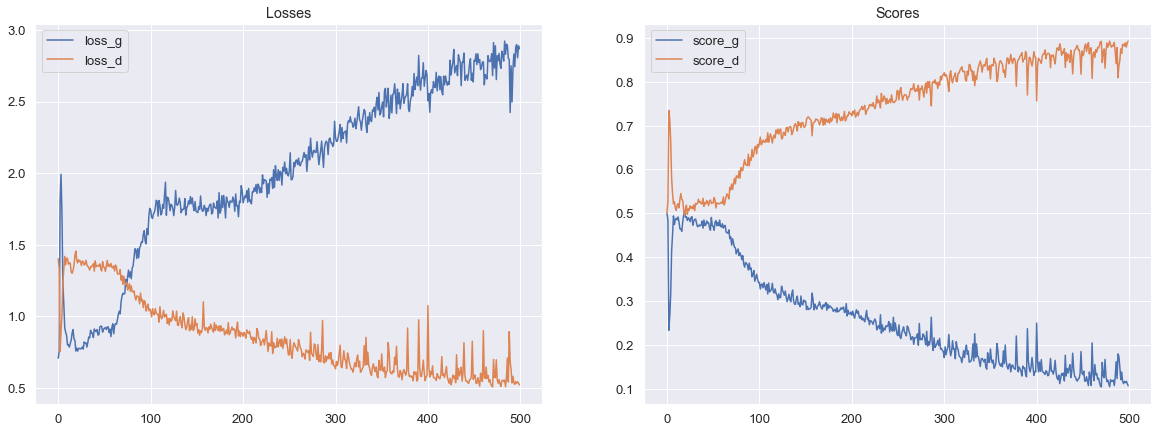

In [18]:
# Визуализируем графики losses и scores
fig, ax = plt.subplots(1,2,figsize=(20,7))
ax[0].plot(losses_g, label='loss_g')
ax[0].plot(losses_d, label='loss_d')
ax[0].set_title('Losses')
ax[0].legend()
ax[1].plot(fake_scores, label='score_g')
ax[1].plot(real_scores, label='score_d')
ax[1].set_title('Scores')
ax[1].legend();

In [182]:
# При необходимости скачайте веса и загрузите в модели.

# !gdown -q --fuzzy https://drive.google.com/file/d/1K_Nl2c6R_J4D0Hp2UW5P4h77ZeqCxh_d/view?usp=sharing
# !unzip weights.zip
# model['generator'].load_state_dict(torch.load('weights/gen_weights.pth'))
# model['discriminator'].load_state_dict(torch.load('weights/discr_weights.pth'))

In [227]:
# Раскомментируйте, чтобы скачать гифку с визуализацией обучения по эпохам.
#!gdown -q --fuzzy https://drive.google.com/file/d/1ATK3m9d48HcT2sFI1bRxrt2f7rB3CuII/view?usp=sharing

**Визуализация обучения**<br>
<img src="learning.gif" width="750" align="center">

Выводы:

* 1. Первые 75 эпох побеждает дискриминатор. Scores также близки к 0.5 первые 75 эпох.
* 2. Дальше и лоссы и скоры начинают расходиться. Дискриминатор всё лучше и лучше распознаёт фейковые изображения.
* 3. Видны "переломы" на графиках ровно на тех эпохах, когда отрабатывают MultiStepLR schedulers.
* 4. В целом картина похожа на графики обучения, которые были и в лекциях и в семинаре. Ну и на те, что представлены в статьях по GANам.
* 5. Пробовал корректировать lr так, чтобы держать и скор близко к 0.5 и лоссы рядом. Прироста качества это не дало.

## Часть 3. Генерация изображений

Генерим 36 случайных векторов, прогоняем через генератор, получаем изображения.

In [213]:
# Определим количество изображений
# Сгенерируем ровно столько случайных векторов
# И сгенерируем изображения.
n_images = 36

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=DEVICE)
fake_images = model["generator"](fixed_latent)

Функция для визуализации (масштабирование передаем аргументом)

In [20]:
# На вход подаются изображения и коэфиициент масштабирования.
def show_images(generated, scale):
  with torch.no_grad():
    size = int(np.sqrt(len(generated)))
    fig, ax = plt.subplots(figsize=(size*scale, size*scale))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(generated).cpu().detach(), nrow=size).permute(1, 2, 0))

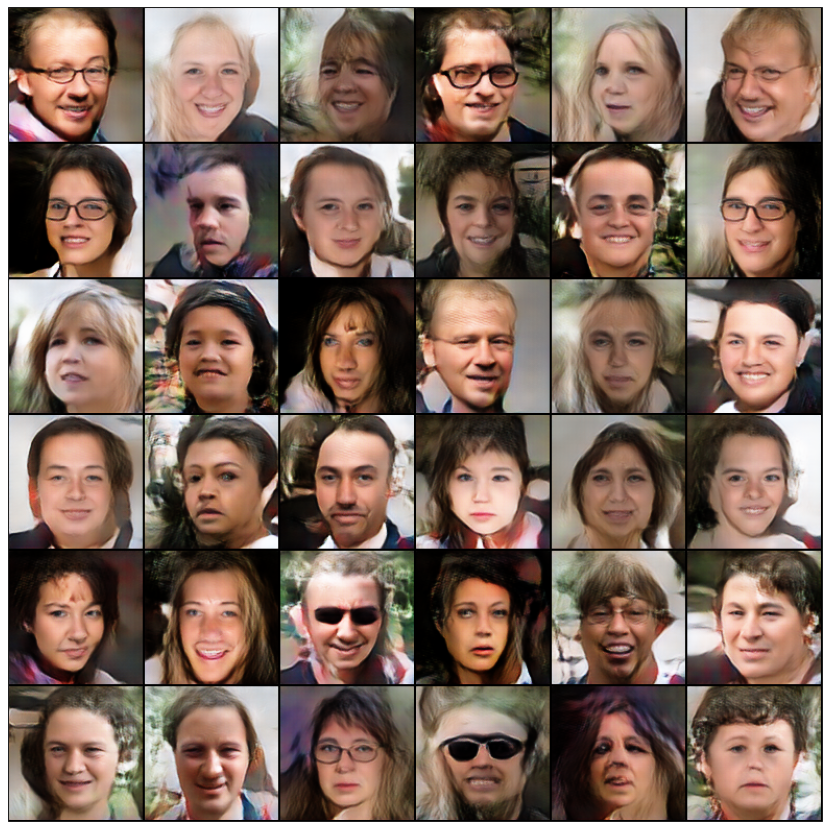

In [214]:
# Визуализируем 36(в данном случае) изображений.
show_images(fake_images, 2.5)

**Выводы:**

**1. Качество получилось не очень. Есть изображения, где лица очень неплохо выглядят, похожи на фотографии.**<br>
**2. В основном всё портят волосы и фон. Возможно стоило сильнее "кропить" изображения.**<br>
**3. Результаты в целом даже чуть лучше чем получившиеся в оригинальной статье по DCGAN**

## Часть 4. Leave-one-out-1-NN classifier accuracy

### 4.1. Подсчет accuracy

Хорошо бы оценивать качествео сгенерированных изображений не только глазами.
Попробуем следующий подход:
  * Генерируем столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присваиваем фейковым метку класса 0, настоящим – 1.
  * Строим leave-one-out оценку: обучаем 1NN Classifier предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте.

Импорт необходимоых библиотек

In [69]:
# Импортируем необходимые библиотеки
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import pandas as pd

Создаем даталоадер, генерируем фейковые изображения.

In [54]:
# Количество изображений в датасете
num_imgs = len(preprocessed_files)
# Создаём такое же количество латентных векторов
fake_vecs = torch.randn(num_imgs, latent_size, 1, 1)
# Грузить будем даталоадером, всё целиком не влезет в память
fake_imgs_loader = DataLoader(fake_vecs, batch_size=64, shuffle=False)
# Создаем пустой тензор, такого же размера как исходный датасет
fake_imgs = torch.empty_like(preprocessed_files)
# Генерируем изображения побатчево и заполняем тензор.
model['generator'].eval()
with torch.no_grad():
    for i,batch in enumerate(fake_imgs_loader):
        batch=batch.to(DEVICE)
        gen_imgs = model['generator'](batch)
        fake_imgs[i*len(batch):i*len(batch)+len(batch)] = gen_imgs
        batch.cpu()
        del batch
        torch.cuda.empty_cache()

Создаём метки и считаем KNN с количеством соседей = 1

In [55]:
# Создаём метки для изображений(половина реальных - 1, половина фейковых - 0)
all_labels = torch.hstack((torch.ones(num_imgs), torch.zeros(num_imgs))).numpy()
# Объединяем все изображения, решейпим(вытягиваем каждое изображение в вектор)
all_imgs = torch.hstack((preprocessed_files, fake_imgs)).numpy().reshape(-1,128*128*3)

In [62]:
# Считаем KNN, записываем реальные и предсказанные классы
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
loo = LeaveOneOut()
preds_list = []
classes_list = []
for train_idx, test_idx in loo.split(all_imgs):
    x_train, x_test = all_imgs[train_idx], all_imgs[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    preds_list.append(y_pred)
    classes_list.append(y_test)

In [148]:
# Запишем всё в датафрейм(так удобно потом будет фильтровать по классам)
loo_df = pd.DataFrame({'classes':np.array(classes_list).ravel(), 'preds': np.array(preds_list).ravel()})
loo_df.head()

,classes,preds
0,1.0,1.0
1,1.0,0.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


Считаем accuracy

In [149]:
# Посчитаем accuracy по всему получившемуся сету, и отдельно по реальным и фейковым изображениям
print(f'Общая accuracy: {accuracy_score(loo_df["classes"], loo_df["preds"])}')
print(f"Accuracy для реальных изображений: {accuracy_score(loo_df[loo_df['classes'] == 1].classes, loo_df[loo_df['classes'] == 1].preds)}")
print(f"Accuracy для фейковых изображений: {accuracy_score(loo_df[loo_df['classes'] == 0].classes, loo_df[loo_df['classes'] == 0].preds)}")

Общая accuracy: 0.49395482023544385
Accuracy для реальных изображений: 0.5007954183900731
Accuracy для фейковых изображений: 0.4871142220808145


**Выводы:**

* 1. Хотелось бы получить accuracy 0.5 - это значило бы, что knn классификатор не может отличить реальные изображения от сгенерированных.
* 2. Ну примерно такую точность и получили. Но при этом визуально отличить сгенерированные изображения от реальных - довольно просто.<br> А значит эта метрика не слишком хорошо отражает результат.
* 3. Возможно стоило обучить например вариационный автоэнкодер и вычислять accuracy уже на скрытом представлении. Но это потребует большого количества времени.

### 4.2. Визуализация распределений

Понижаем размерность скрытого представления (тем же TSNE). Визуализируем распределения фейковых и реальных изображений.

In [104]:
# Импортируем необходимые библиотеки
from sklearn.manifold import TSNE
import seaborn as sns

In [157]:
# Обучаем TSNE и трансформим весь датасет(и реальные и фейковые изображения)
embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(all_imgs)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [165]:
# Сохраним в датафрейм
tsne_df = pd.DataFrame({'x':embedded[:,0], 'y':embedded[:,1], 'class':np.array(classes_list).ravel()})
tsne_df['class'] = tsne_df['class'].map({1:'real', 0:'fake'})
tsne_df.head()

,x,y,class
0,38.821808,-27.380987,real
1,-43.430172,-13.482634,real
2,-1.047005,60.800457,real
3,-8.971863,4.020405,real
4,-5.276000,-36.108990,real


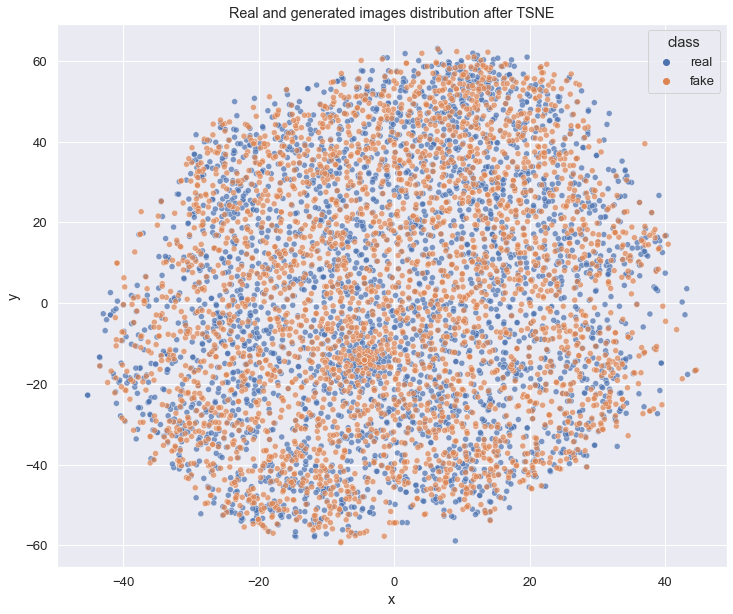

In [177]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='class', alpha=0.7)
plt.title('Real and generated images distribution after TSNE');

**Выводы:**

**Визуально разделить реальные и фейковые изображения по этому распределению практически нельзя.<br>А это значит что они сильно похожи и вероятно мы генерируем изображения из того, же распределения, что и реальные фото.<br>Это вот ровно та картина, которую хотелось бы увидеть. Если бы можно было чётко выделить кластеры фейковых и реальных изображений - ну значит и визуально они бы очень сильно отличались.**

**В целом результат устраивает. Хотелось бы конечно еще более реалистичные изображения генерировать, но, насколько я понял,<br> этого возможно добиться только используя более сложные архитектуры, такие как Multi-scale gradient GAN например.**

<video src="https://drive.google.com/file/d/1ATK3m9d48HcT2sFI1bRxrt2f7rB3CuII/view?usp=sharing" width="750" align="center">